# ML Quest #1: Demand Forecasting
https://www.patreon.com/ZazenCodes

## Part 2: Feature Engineering and Modeling

## Sections
1. Load and Clean Data (from Part 1)
2. Encode Categorical Features
3. Transform Numeric Features
4. Feature Engineering for Temporal Data
5. Lag Features and Moving Averages
6. Simple Model
7. Train-Test Splits
8. Gradient-Boosted Model Hyperparameter Optimization
9. Train a Stack of Models

## Setup

Refer to the Part 1 notebook for setup instructions.

## 1. Load and Clean Data

In [1]:
# Apply cleaning from Part 1 notebook

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler

def load_meal_demand_dataset(file_name, data_path="../data/"):

    print("Loading dataset")
    file_path = Path(data_path) / file_name
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows from {file_path}:")
    print(df.dtypes)
    print(df.describe())
    print(df)
    print("Done loading dataset")
    print("------------------------------------------------------")

    print("Cleaning dataset")
    df = parse_num_orders(df)
    df = clean_num_orders(df)
    df = remove_low_temporal_coverage(df)
    print("Done cleaning dataset")
    print("------------------------------------------------------")

    return df


def parse_num_orders(df):
    print(f"Length before parsing num_orders: {len(df)}")

    df["num_orders"] = df["num_orders"].fillna("").str.replace(",", "")
    null_orders = df["num_orders"] == ""
    df = df[~null_orders].copy()
    df["num_orders"] = pd.to_numeric(df["num_orders"])

    print(f"Length after parsing num_orders:  {len(df)}")
    return df


def clean_num_orders(df):
    print(f"Length before cleaning num_orders: {len(df)}")

    max_num_orders = 6.902760e+03
    negative_orders = df.num_orders < 0
    zero_orders = df.num_orders == 0
    huge_orders = df.num_orders > max_num_orders
    df = df[~(negative_orders | zero_orders | huge_orders)].copy()

    print(f"Length after cleaning num_orders:  {len(df)}")
    return df

def remove_low_temporal_coverage(df):
    print(f"Length before removing low temporal coverage records: {len(df)}")
    df = df[~df.city_name.isin(("Osprey Point",))].copy()
    print(f"Length after removing low temporal coverage records:  {len(df)}")
    return df

In [2]:
df = load_meal_demand_dataset("meal_demand_historical.csv")

Loading dataset
Loaded 456548 rows from ../data/meal_demand_historical.csv:
week_number                int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                object
op_area                  float64
city_name                 object
meal_name                 object
meal_category             object
meal_type                 object
dtype: object
         week_number  checkout_price     base_price  emailer_for_promotion  \
count  456548.000000   456548.000000  456548.000000          456548.000000   
mean       74.768771      332.238933     354.156627               0.081152   
std        41.524956      152.939723     160.715914               0.273069   
min         1.000000        2.970000      55.350000               0.000000   
25%        39.000000      228.950000     243.500000               0.000000   
50%        76.000000      296.820000     310.460000               0.000000   
7

In [3]:
df

,week_number,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,city_name,meal_name,meal_category,meal_type
0,1,136.83,152.29,0,0,177,2.0,Brackenbury,Mushroom Stew,Vegetarian,main
1,1,136.83,135.83,0,0,270,2.0,Brackenbury,Dwarven Meat Pie,Meat,main
2,1,134.86,135.86,0,0,189,2.0,Brackenbury,Dragonfire Chili,Meat,main
3,1,339.50,437.53,0,0,54,2.0,Brackenbury,Stuffed Mushrooms,Vegetarian,starter
4,1,243.50,242.50,0,0,40,2.0,Brackenbury,Grilled Trout with Lemon,Seafood,main
...,...,...,...,...,...,...,...,...,...,...,...
456543,145,484.09,484.09,0,0,68,4.5,Meadowbrook,Fire-Grilled Venison,Meat,main
456544,145,482.09,482.09,0,0,42,4.5,Meadowbrook,Forest Berry Pie,Other,dessert
456545,145,237.68,321.07,0,0,501,4.5,Meadowbrook,Savory Meat Pies,Meat,main
456546,145,243.50,313.34,0,0,729,4.5,Meadowbrook,Apple and Raisin Bread,Other,dessert


In [4]:
df.dtypes

week_number                int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
op_area                  float64
city_name                 object
meal_name                 object
meal_category             object
meal_type                 object
dtype: object

## 2. Encode Categorical Features

In [5]:
# Apply one-hot encoding

from sklearn.preprocessing import OneHotEncoder
meal_info_ohe = OneHotEncoder()
meal_info_ohe.fit(df[["meal_category", "meal_type"]].values)

OneHotEncoder()

In [6]:
ohe_vals = meal_info_ohe.transform(df[["meal_category", "meal_type"]].values)
ohe_vals

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 893464 stored elements and shape (446732, 9)>

In [7]:
ohe_vals.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [8]:
ohe_vals.toarray()[2821]

array([1., 0., 0., 0., 0., 0., 1., 0., 0.])

In [9]:
meal_info_ohe.inverse_transform([ohe_vals.toarray()[2821]])

array([['Meat', 'main']], dtype=object)

In [10]:
meal_info_ohe.inverse_transform(ohe_vals.toarray()[237:283])

array([['Vegetarian', 'starter'],
       ['Seafood', 'main'],
       ['Meat', 'starter'],
       ['Meat', 'main'],
       ['Vegetarian', 'starter'],
       ['Vegetarian', 'starter'],
       ['Vegetarian', 'starter'],
       ['Meat', 'main'],
       ['Seafood', 'main'],
       ['Vegetarian', 'starter'],
       ['Meat', 'main'],
       ['Seafood', 'main'],
       ['Meat', 'main'],
       ['Other', 'starter'],
       ['Vegetarian', 'starter'],
       ['Vegetarian', 'side'],
       ['Other', 'starter'],
       ['Meat', 'main'],
       ['Seafood', 'starter'],
       ['Meat', 'main'],
       ['Vegetarian', 'main'],
       ['Vegetarian', 'side'],
       ['Other', 'starter'],
       ['Vegetarian', 'main'],
       ['Meat', 'main'],
       ['Vegetarian', 'starter'],
       ['Other', 'dessert'],
       ['Vegetarian', 'starter'],
       ['Other', 'dessert'],
       ['Vegetarian', 'main'],
       ['Vegetarian', 'starter'],
       ['Vegetarian', 'side'],
       ['Other', 'dessert'],
       ['Other',

In [11]:
dir(meal_info_ohe)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_X',
 '_check_feature_names',
 '_check_get_feature_name_combiner',
 '_check_infrequent_enabled',
 '_check_n_features',
 '_compute_n_features_outs',
 '_compute_transformed_categories',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_drop_idx_after_grouping',
 '_fit',
 '_fit_infrequent_category_mapping',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_identify_infrequent',
 '_infrequent_enabled',
 '_map_drop_idx_to_inf

In [12]:
meal_info_ohe.categories_

[array(['Meat', 'Other', 'Seafood', 'Vegetarian'], dtype=object),
 array(['beverage', 'dessert', 'main', 'side', 'starter'], dtype=object)]

In [13]:
def get_ohe_columns(ohe_encoder):
    columns = []
    for cols in ohe_encoder.categories_:
        columns.extend(list(cols))
    return columns

get_ohe_columns(meal_info_ohe)

['Meat',
 'Other',
 'Seafood',
 'Vegetarian',
 'beverage',
 'dessert',
 'main',
 'side',
 'starter']

In [14]:
pd.DataFrame(ohe_vals.toarray(), columns=get_ohe_columns(meal_info_ohe)).astype(int)

,Meat,Other,Seafood,Vegetarian,beverage,dessert,main,side,starter
0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
446727,1,0,0,0,0,0,1,0,0
446728,0,1,0,0,0,1,0,0,0
446729,1,0,0,0,0,0,1,0,0
446730,0,1,0,0,0,1,0,0,0


In [15]:
ohe_vals.shape

(446732, 9)

In [16]:
df_ohe = pd.DataFrame(ohe_vals.toarray(), columns=get_ohe_columns(meal_info_ohe)).astype(int)

In [17]:
pd.concat((df.reset_index(drop=True), df_ohe.reset_index(drop=True)), axis=1)

,week_number,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,city_name,meal_name,meal_category,meal_type,Meat,Other,Seafood,Vegetarian,beverage,dessert,main,side,starter
0,1,136.83,152.29,0,0,177,2.0,Brackenbury,Mushroom Stew,Vegetarian,main,0,0,0,1,0,0,1,0,0
1,1,136.83,135.83,0,0,270,2.0,Brackenbury,Dwarven Meat Pie,Meat,main,1,0,0,0,0,0,1,0,0
2,1,134.86,135.86,0,0,189,2.0,Brackenbury,Dragonfire Chili,Meat,main,1,0,0,0,0,0,1,0,0
3,1,339.50,437.53,0,0,54,2.0,Brackenbury,Stuffed Mushrooms,Vegetarian,starter,0,0,0,1,0,0,0,0,1
4,1,243.50,242.50,0,0,40,2.0,Brackenbury,Grilled Trout with Lemon,Seafood,main,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446727,145,484.09,484.09,0,0,68,4.5,Meadowbrook,Fire-Grilled Venison,Meat,main,1,0,0,0,0,0,1,0,0
446728,145,482.09,482.09,0,0,42,4.5,Meadowbrook,Forest Berry Pie,Other,dessert,0,1,0,0,0,1,0,0,0
446729,145,237.68,321.07,0,0,501,4.5,Meadowbrook,Savory Meat Pies,Meat,main,1,0,0,0,0,0,1,0,0
446730,145,243.50,313.34,0,0,729,4.5,Meadowbrook,Apple and Raisin Bread,Other,dessert,0,1,0,0,0,1,0,0,0


In [18]:
{i+1: name for i, name in enumerate(df.city_name.unique())}

{1: 'Brackenbury',
 2: 'Aldershade',
 3: 'Oakhaven',
 4: 'Moonshadow',
 5: 'Briarwood',
 6: 'Pinecrest',
 7: 'Invermere',
 8: 'Jadehaven',
 9: 'Cypress Hollow',
 10: 'Xanadu',
 11: 'Pemberton',
 12: 'Nettlefield',
 13: 'Brightwater',
 14: 'Candlekeep',
 15: 'Oakenspire',
 16: 'Willowgrove',
 17: "Kite's Nest",
 18: 'Quillbrook',
 19: 'Driftwood',
 20: 'Duskbrook',
 21: 'Everspring',
 22: 'Elmswood',
 23: 'Foxglove',
 24: 'Lighthaven',
 25: 'Mirthwood',
 26: 'Pinewatch',
 27: 'Quagmire',
 28: 'Ridgefield',
 29: 'Copperton',
 30: 'Dragonspur',
 31: 'Redstone',
 32: 'Quicksilver',
 33: 'Stonehaven',
 34: 'Gallows End',
 35: 'Frosthaven',
 36: 'Glimmerglen',
 37: 'Ravenwood',
 38: 'Timberfall',
 39: 'Northwatch',
 40: 'Harrowdale',
 41: 'Underhill',
 42: 'Hawthorn',
 43: 'Silverstone',
 44: 'Ivory Peak',
 45: 'Nightfall',
 46: 'Thornfield',
 47: 'Valewood',
 48: 'Yarrowford',
 49: 'Zephyrvale',
 50: 'Windridge',
 51: 'Eaglecrest',
 52: 'Stormwatch',
 53: 'Tanglewood',
 54: 'Juniper Hill',


In [19]:
# Encode city names using an ordered strategy

df.groupby("city_name").num_orders.sum().sort_values().reset_index()

,city_name,num_orders
0,Elmswood,420629
1,Fernwood,494064
2,Nettlefield,631632
3,Copperton,673993
4,Kite's Nest,686521
...,...,...
71,Mirthwood,2982266
72,Invermere,3079949
73,Greenshade,3329595
74,Kingsholm,3649408


In [20]:
df.groupby("city_name").num_orders.sum().sort_values().reset_index().city_name.tolist()

['Elmswood',
 'Fernwood',
 'Nettlefield',
 'Copperton',
 "Kite's Nest",
 'Harrowdale',
 'Pemberton',
 'Underhill',
 'Brackenbury',
 'Ulderville',
 'Cypress Hollow',
 'Silverstone',
 'Pinewatch',
 'Lindenhurst',
 'Everspring',
 'Frosthaven',
 'Verdant',
 'Ironforge',
 'Redstone',
 'Valewood',
 'Ivory Peak',
 'Jasperwood',
 'Juniper Hill',
 'Glimmerglen',
 'Hawthorn',
 'Aspenfall',
 'Windridge',
 'Jadehaven',
 'Zarendale',
 'Lighthaven',
 'Ravenwood',
 'Winterhold',
 'Meadowbrook',
 'Timberfall',
 'Oakenspire',
 'Moonshadow',
 'Yarrowford',
 'Foxglove',
 'Stonehaven',
 'Gallows End',
 'Nightfall',
 'Hollowcrest',
 'Zephyrvale',
 'Kestrelcliff',
 'Candlekeep',
 'Northwatch',
 'Eaglecrest',
 'Vesperwood',
 'Oakhaven',
 'Pinecrest',
 'Duskbrook',
 'Lakeshire',
 'Ashenport',
 'Dragonspur',
 'Yewshade',
 'Willowgrove',
 'Quagmire',
 'Westfall',
 'Xanadu',
 'Umbermoor',
 'Brightwater',
 'Ridgefield',
 'Amberhill',
 'Driftwood',
 'Brookhollow',
 'Quillbrook',
 'Quicksilver',
 'Thornfield',
 'Ta

In [21]:
ordered_city_names = df.groupby("city_name").num_orders.sum().sort_values().reset_index("city_name").drop(columns="num_orders").reset_index().set_index("city_name").to_dict()["index"]

In [22]:
ordered_city_names

{'Elmswood': 0,
 'Fernwood': 1,
 'Nettlefield': 2,
 'Copperton': 3,
 "Kite's Nest": 4,
 'Harrowdale': 5,
 'Pemberton': 6,
 'Underhill': 7,
 'Brackenbury': 8,
 'Ulderville': 9,
 'Cypress Hollow': 10,
 'Silverstone': 11,
 'Pinewatch': 12,
 'Lindenhurst': 13,
 'Everspring': 14,
 'Frosthaven': 15,
 'Verdant': 16,
 'Ironforge': 17,
 'Redstone': 18,
 'Valewood': 19,
 'Ivory Peak': 20,
 'Jasperwood': 21,
 'Juniper Hill': 22,
 'Glimmerglen': 23,
 'Hawthorn': 24,
 'Aspenfall': 25,
 'Windridge': 26,
 'Jadehaven': 27,
 'Zarendale': 28,
 'Lighthaven': 29,
 'Ravenwood': 30,
 'Winterhold': 31,
 'Meadowbrook': 32,
 'Timberfall': 33,
 'Oakenspire': 34,
 'Moonshadow': 35,
 'Yarrowford': 36,
 'Foxglove': 37,
 'Stonehaven': 38,
 'Gallows End': 39,
 'Nightfall': 40,
 'Hollowcrest': 41,
 'Zephyrvale': 42,
 'Kestrelcliff': 43,
 'Candlekeep': 44,
 'Northwatch': 45,
 'Eaglecrest': 46,
 'Vesperwood': 47,
 'Oakhaven': 48,
 'Pinecrest': 49,
 'Duskbrook': 50,
 'Lakeshire': 51,
 'Ashenport': 52,
 'Dragonspur': 53,

In [23]:
ordered_city_names = df.groupby("city_name").num_orders.sum().sort_values().reset_index().city_name.tolist()

In [24]:
class OrderedCategoryEncoder:
    def __init__(self):
        self.categories_: list[str] = None
        self.category_map: dict[str: int] = None
        self.inverse_category_map: dict[int: str] = None

    def fit(self, ordered_categories: list[str]):
        self.categories_ = ordered_categories
        self.category_map = {category: i+1 for i, category in enumerate(ordered_categories)}
        self.inverse_category_map = {i+1: category for i, category in enumerate(ordered_categories)}

    def transform(self, values: list[str]) -> np.array:
        if set(values) - set(self.category_map):
            for value in values:
                if value not in self.category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.category_map[value] for value in values])
    
    def inverse_transform(self, values: list[int]) -> np.array:
        if set(values) - set(self.inverse_category_map):
            for value in values:
                if value not in self.inverse_category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.inverse_category_map[value] for value in values])

    

In [25]:
city_name_encoder = OrderedCategoryEncoder()
city_name_encoder.fit(ordered_city_names)
encoded_city_names = city_name_encoder.transform(df.city_name.values)
decoded_city_names = city_name_encoder.inverse_transform(encoded_city_names)

In [26]:
sample_idx = [82,831, 44421]
print("Encoded city names from sample:", encoded_city_names[sample_idx])
print("Decoded city names from sample:", decoded_city_names[sample_idx])

Encoded city names from sample: [49 38 17]
Decoded city names from sample: ['Oakhaven' 'Foxglove' 'Verdant']


In [27]:
ordered_meal_names = df.groupby("meal_name").num_orders.sum().sort_values().reset_index().meal_name.tolist()

In [28]:
meal_name_encoder = OrderedCategoryEncoder()
meal_name_encoder.fit(ordered_meal_names)
encoded_meal_names = meal_name_encoder.transform(df.meal_name.values)

In [29]:
encoded_meal_names.shape

(446732,)

In [30]:
# Full feature encoding pipeline

def encode_features(df):
    print("Encoding dataset")
    meal_info_ohe = OneHotEncoder()
    city_name_encoder = OrderedCategoryEncoder()
    meal_name_encoder = OrderedCategoryEncoder()
    df = apply_ohe_encoding(df, meal_info_ohe)
    df = apply_ordinal_encoding(df, city_name_encoder, meal_name_encoder)
    print("Done encoding dataset")
    print("------------------------------------------------------")

    artifacts = {}
    artifacts["meal_info"] = meal_info_ohe
    artifacts["city_name"] = city_name_encoder
    artifacts["meal_name"] = meal_name_encoder

    return df, artifacts


class OrderedCategoryEncoder:
    def __init__(self):
        self.categories_: list[str] = None
        self.category_map: dict[str: int] = None
        self.inverse_category_map: dict[int: str] = None

    def fit(self, ordered_categories: list[str]):
        self.categories_ = ordered_categories
        self.category_map = {category: i+1 for i, category in enumerate(ordered_categories)}
        self.inverse_category_map = {i+1: category for i, category in enumerate(ordered_categories)}

    def transform(self, values: list[str]) -> np.array:
        if set(values) - set(self.category_map):
            for value in values:
                if value not in self.category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.category_map[value] for value in values])
    
    def inverse_transform(self, values: list[int]) -> np.array:
        if set(values) - set(self.inverse_category_map):
            for value in values:
                if value not in self.inverse_category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.inverse_category_map[value] for value in values])


def get_ohe_columns(ohe_encoder):
    columns = []
    for cols in ohe_encoder.categories_:
        columns.extend(list(cols))
    return columns


def apply_ohe_encoding(df, meal_info_ohe):
    print("Applying one-hot-encoding to meal_category and meal_type")
    ohe_vals = meal_info_ohe.fit_transform(df[["meal_category", "meal_type"]].values).toarray()
    df_ohe = pd.DataFrame(ohe_vals, columns=get_ohe_columns(meal_info_ohe)).astype(int)
    df = pd.concat((df.reset_index(drop=True), df_ohe.reset_index(drop=True)), axis=1)
    df = df.drop(columns=["meal_category", "meal_type"])
    return df


def apply_ordinal_encoding(df, city_name_encoder, meal_name_encoder):
    print("Applying ordered categorical encoding to city_name")
    ordered_city_names = (
        df.groupby("city_name").num_orders.sum().sort_values()
        .reset_index("city_name").drop(columns="num_orders")
        .reset_index().set_index("city_name").to_dict()["index"]
    )
    city_name_encoder.fit(ordered_city_names)
    df["city_id"] = city_name_encoder.transform(df.city_name.values)

    print("Applying ordered categorical encoding to meal_name")
    ordered_meal_names = (
        df.groupby("meal_name").num_orders.sum().sort_values()
        .reset_index("meal_name").drop(columns="num_orders")
        .reset_index().set_index("meal_name").to_dict()["index"]
    )
    meal_name_encoder.fit(ordered_meal_names)
    df["meal_id"] = meal_name_encoder.transform(df.meal_name.values)

    df = df.drop(columns=["city_name", "meal_name"])

    return df

In [31]:
df, encoders = encode_features(df)

Encoding dataset
Applying one-hot-encoding to meal_category and meal_type
Applying ordered categorical encoding to city_name
Applying ordered categorical encoding to meal_name
Done encoding dataset
------------------------------------------------------


In [32]:
df

,week_number,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,dessert,main,side,starter,city_id,meal_id
0,1,136.83,152.29,0,0,177,2.0,0,0,0,1,0,0,1,0,0,9,50
1,1,136.83,135.83,0,0,270,2.0,1,0,0,0,0,0,1,0,0,9,48
2,1,134.86,135.86,0,0,189,2.0,1,0,0,0,0,0,1,0,0,9,37
3,1,339.50,437.53,0,0,54,2.0,0,0,0,1,0,0,0,0,1,9,8
4,1,243.50,242.50,0,0,40,2.0,0,0,1,0,0,0,1,0,0,9,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446727,145,484.09,484.09,0,0,68,4.5,1,0,0,0,0,0,1,0,0,33,17
446728,145,482.09,482.09,0,0,42,4.5,0,1,0,0,0,1,0,0,0,33,15
446729,145,237.68,321.07,0,0,501,4.5,1,0,0,0,0,0,1,0,0,33,41
446730,145,243.50,313.34,0,0,729,4.5,0,1,0,0,0,1,0,0,0,33,39


In [33]:
df.dtypes

week_number                int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
op_area                  float64
Meat                       int64
Other                      int64
Seafood                    int64
Vegetarian                 int64
beverage                   int64
dessert                    int64
main                       int64
side                       int64
starter                    int64
city_id                    int64
meal_id                    int64
dtype: object

In [34]:
df.to_csv(f"../data/full_clean_encoded.csv", index=False)

In [35]:
encoders.keys()

dict_keys(['meal_info', 'city_name', 'meal_name'])

In [36]:
from pathlib import Path
from pickle import dump, load

In [37]:
def store_encoders(encoders, artifact_path="../artifacts"):
    Path(artifact_path).mkdir(exist_ok=True, parents=True)
    for name, obj in encoders.items():
        with open(Path(artifact_path) / f"{name}_encoder.pkl", "wb") as f:
            dump(obj, f)

store_encoders(encoders)


In [38]:
!ls ../artifacts

boosted_tree.pkl         meal_info_encoder.pkl    price_scaler_encoder.pkl
city_name_encoder.pkl    meal_name_encoder.pkl


## 3. Transform Numeric Features

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
# Apply scaling from Part 1 notebook

def scale_features(df):
    print("------------------------------------------------------")
    print("Scaling dataset")
    price_scaler = StandardScaler()
    df = apply_scaling(df, price_scaler)
    print("Done scaling dataset")
    print("------------------------------------------------------")

    artifacts = {}
    artifacts["price_scaler"] = price_scaler

    return df, artifacts

def apply_scaling(df, price_scaler):
    df["base_price_normed"] = price_scaler.fit_transform(df.base_price.values.reshape(-1,1))
    df["checkout_price_normed"] = price_scaler.transform(df.checkout_price.values.reshape(-1,1))
    # df["num_orders_log"] = df.num_orders.apply(np.log)
    df = df.drop(columns=["base_price", "checkout_price"]) #, "num_orders"])
    return df


df, scaler_artifacts = scale_features(df)
encoders.update(scaler_artifacts)

------------------------------------------------------
Scaling dataset
Done scaling dataset
------------------------------------------------------


In [41]:
def add_price_features(df):
    print("Adding price features")
    df["price_diff"] = df.base_price_normed - df.checkout_price_normed
    print("Done adding price features")
    return df

df = add_price_features(df)

Adding price features
Done adding price features


In [42]:
store_encoders(encoders)

In [43]:
!ls ../artifacts/

boosted_tree.pkl         meal_info_encoder.pkl    price_scaler_encoder.pkl
city_name_encoder.pkl    meal_name_encoder.pkl


## 4. Feature Engineering for Temporal Data

In [44]:
# Feature binning

def apply_yearly_offset_by_month(month_num):
    if month_num <= 12:
        return month_num
    elif month_num <= 24:
        return month_num - 12
    elif month_num <= 36:
        return month_num - 24
    else:
        raise NotImplementedError(month_num)

month_num = (df.week_number // (52/12)).astype(int).apply(apply_yearly_offset_by_month) + 1
month_num

0          1
1          1
2          1
3          1
4          1
          ..
446727    10
446728    10
446729    10
446730    10
446731    10
Name: week_number, Length: 446732, dtype: int64

In [45]:
def apply_yearly_offset_by_quarter(querter_num):
    if querter_num <= 4:
        return querter_num
    elif querter_num <= 8:
        return querter_num - 4
    elif querter_num <= 12:
        return querter_num - 8
    else:
        raise NotImplementedError(month_num)


quarter_num = (df.week_number // (52/4)).astype(int).apply(apply_yearly_offset_by_quarter) + 1
quarter_num

0         1
1         1
2         1
3         1
4         1
         ..
446727    4
446728    4
446729    4
446730    4
446731    4
Name: week_number, Length: 446732, dtype: int64

In [46]:
year_num = (df.week_number // 52).astype(int) + 1
year_num

0         1
1         1
2         1
3         1
4         1
         ..
446727    3
446728    3
446729    3
446730    3
446731    3
Name: week_number, Length: 446732, dtype: int64

In [47]:
def add_calendar_features(df):
    print("Adding calendar features")
    df["month_num"] = (df.week_number // (52/12)).astype(int).apply(apply_yearly_offset_by_month) + 1
    df["quarter_num"] = (df.week_number // (52/4)).astype(int).apply(apply_yearly_offset_by_quarter) + 1
    df["year_num"] = (df.week_number // 52).astype(int) + 1
    print("Done adding calendar features")
    return df

df = add_calendar_features(df)

Adding calendar features
Done adding calendar features


In [48]:
df

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,side,starter,city_id,meal_id,base_price_normed,checkout_price_normed,price_diff,month_num,quarter_num,year_num
0,1,0,0,177,2.0,0,0,0,1,0,...,0,0,9,50,-1.255789,-1.352007,0.096219,1,1,1
1,1,0,0,270,2.0,1,0,0,0,0,...,0,0,9,48,-1.358231,-1.352007,-0.006224,1,1,1
2,1,0,0,189,2.0,1,0,0,0,0,...,0,0,9,37,-1.358044,-1.364268,0.006224,1,1,1
3,1,0,0,54,2.0,0,0,0,1,0,...,0,1,9,8,0.519464,-0.090647,0.610111,1,1,1
4,1,0,0,40,2.0,0,0,1,0,0,...,0,0,9,23,-0.694347,-0.688123,-0.006224,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446727,145,0,0,68,4.5,1,0,0,0,0,...,0,0,33,17,0.809241,0.809241,0.000000,10,4,3
446728,145,0,0,42,4.5,0,1,0,0,0,...,0,0,33,15,0.796793,0.796793,0.000000,10,4,3
446729,145,0,0,501,4.5,1,0,0,0,0,...,0,0,33,41,-0.205350,-0.724346,0.518996,10,4,3
446730,145,0,0,729,4.5,0,1,0,0,0,...,0,0,33,39,-0.253459,-0.688123,0.434664,10,4,3


## 5. Lag Features and Moving Averages

In [49]:
df.num_orders

0         177
1         270
2         189
3          54
4          40
         ... 
446727     68
446728     42
446729    501
446730    729
446731    162
Name: num_orders, Length: 446732, dtype: int64

In [50]:
g = ["city_id", "meal_id"]
df.sort_values("week_number", ascending=True).groupby(g).num_orders.shift(-1)

0         323.0
1898      514.0
1899      946.0
1900      148.0
1901      432.0
          ...  
444611      NaN
444612      NaN
444613      NaN
444615      NaN
446731      NaN
Name: num_orders, Length: 446732, dtype: float64

In [51]:
from IPython.display import display
with pd.option_context("display.max_rows", 1000000):
    display(df.head(100))

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,side,starter,city_id,meal_id,base_price_normed,checkout_price_normed,price_diff,month_num,quarter_num,year_num
0,1,0,0,177,2.0,0,0,0,1,0,...,0,0,9,50,-1.255789,-1.352007,0.096219,1,1,1
1,1,0,0,270,2.0,1,0,0,0,0,...,0,0,9,48,-1.358231,-1.352007,-0.006224,1,1,1
2,1,0,0,189,2.0,1,0,0,0,0,...,0,0,9,37,-1.358044,-1.364268,0.006224,1,1,1
3,1,0,0,54,2.0,0,0,0,1,0,...,0,1,9,8,0.519464,-0.090647,0.610111,1,1,1
4,1,0,0,40,2.0,0,0,1,0,0,...,0,0,9,23,-0.694347,-0.688123,-0.006224,1,1,1
5,1,0,0,28,2.0,1,0,0,0,0,...,0,1,9,18,-0.633790,-0.640014,0.006224,1,1,1
6,1,0,0,190,2.0,1,0,0,0,0,...,0,0,9,38,-1.056194,-1.062418,0.006224,1,1,1
7,1,0,0,391,2.0,0,0,0,1,0,...,0,1,9,42,-1.062418,-1.068642,0.006224,1,1,1
8,1,0,0,472,2.0,0,0,0,1,0,...,0,1,9,46,-1.008271,-1.002048,-0.006224,1,1,1
9,1,0,1,676,2.0,0,0,0,1,0,...,0,1,9,31,0.187429,-0.175165,0.362594,1,1,1


In [52]:
df.head()

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,side,starter,city_id,meal_id,base_price_normed,checkout_price_normed,price_diff,month_num,quarter_num,year_num
0,1,0,0,177,2.0,0,0,0,1,0,...,0,0,9,50,-1.255789,-1.352007,0.096219,1,1,1
1,1,0,0,270,2.0,1,0,0,0,0,...,0,0,9,48,-1.358231,-1.352007,-0.006224,1,1,1
2,1,0,0,189,2.0,1,0,0,0,0,...,0,0,9,37,-1.358044,-1.364268,0.006224,1,1,1
3,1,0,0,54,2.0,0,0,0,1,0,...,0,1,9,8,0.519464,-0.090647,0.610111,1,1,1
4,1,0,0,40,2.0,0,0,1,0,0,...,0,0,9,23,-0.694347,-0.688123,-0.006224,1,1,1


In [53]:
df

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,side,starter,city_id,meal_id,base_price_normed,checkout_price_normed,price_diff,month_num,quarter_num,year_num
0,1,0,0,177,2.0,0,0,0,1,0,...,0,0,9,50,-1.255789,-1.352007,0.096219,1,1,1
1,1,0,0,270,2.0,1,0,0,0,0,...,0,0,9,48,-1.358231,-1.352007,-0.006224,1,1,1
2,1,0,0,189,2.0,1,0,0,0,0,...,0,0,9,37,-1.358044,-1.364268,0.006224,1,1,1
3,1,0,0,54,2.0,0,0,0,1,0,...,0,1,9,8,0.519464,-0.090647,0.610111,1,1,1
4,1,0,0,40,2.0,0,0,1,0,0,...,0,0,9,23,-0.694347,-0.688123,-0.006224,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446727,145,0,0,68,4.5,1,0,0,0,0,...,0,0,33,17,0.809241,0.809241,0.000000,10,4,3
446728,145,0,0,42,4.5,0,1,0,0,0,...,0,0,33,15,0.796793,0.796793,0.000000,10,4,3
446729,145,0,0,501,4.5,1,0,0,0,0,...,0,0,33,41,-0.205350,-0.724346,0.518996,10,4,3
446730,145,0,0,729,4.5,0,1,0,0,0,...,0,0,33,39,-0.253459,-0.688123,0.434664,10,4,3


In [54]:

g = ["city_id", "meal_id"]
df.groupby(g).num_orders.rolling(4).mean().reset_index().sort_values("level_2").drop(columns=g).set_index("level_2").num_orders

level_2
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
446727     91.50
446728     23.75
446729    483.00
446730    604.75
446731    189.50
Name: num_orders, Length: 446732, dtype: float64

In [55]:
with pd.option_context("display.max_rows", 10000):
    s =df.groupby(g).num_orders.shift(52)
    display(s)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
446727     40.0
446728     26.0
446729    244.0
446730    540.0
446731    284.0
Name: num_orders, Length: 446732, dtype: float64

In [56]:
def add_rolling_features(df_):
    df = df_.sort_values("week_number", ascending=True).copy()

    print("Adding rolling features")

    g = ["city_id", "meal_id"]

    # Shift target (predict for next week)
    df["next_week_num_orders"] = df.groupby(g).num_orders.shift(-1)

    # Num next week orders from last year
    df["num_orders_last_year"] = df.groupby(g).next_week_num_orders.shift(52)

    # Num orders from past week
    df["num_orders_last_week"] = df.groupby(g).num_orders.shift(1)

    # Num orders rolling average past 4 weeks
    df["num_orders_rolling_4_weeks"] = (
        df.groupby(g).next_week_num_orders.rolling(4).mean().reset_index().sort_values("level_2").drop(columns=g).set_index("level_2").next_week_num_orders
    )

    # Num orders rolling average past 16 weeks
    df["num_orders_rolling_16_weeks"] = (
        df.groupby(g).next_week_num_orders.rolling(16).mean().reset_index().sort_values("level_2").drop(columns=g).set_index("level_2").next_week_num_orders
    )

    # Num order rolling averages from same week last year
    df["num_orders_last_year_rolling_4_weeks"] = df.groupby(g).num_orders_rolling_4_weeks.shift(52)
    df["num_orders_last_year_rolling_16_weeks"] = df.groupby(g).num_orders_rolling_16_weeks.shift(52)

    # Drop newly introduced nulls (i.e. the first year of data, and the last week!)
    df_nulls = df[df.isnull().any(axis=1)].copy()
    df = df.dropna().copy()

    print("Done adding rolling features")
    return df, df_nulls


_, df_nulls = add_rolling_features(df)

Adding rolling features
Done adding rolling features


In [57]:
# Explore result

df_nulls

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,month_num,quarter_num,year_num,next_week_num_orders,num_orders_last_year,num_orders_last_week,num_orders_rolling_4_weeks,num_orders_rolling_16_weeks,num_orders_last_year_rolling_4_weeks,num_orders_last_year_rolling_16_weeks
0,1,0,0,177,2.0,0,0,0,1,0,...,1,1,1,323.0,NaN,NaN,NaN,NaN,NaN,NaN
1898,1,0,0,865,7.0,1,0,0,0,0,...,1,1,1,514.0,NaN,NaN,NaN,NaN,NaN,NaN
1899,1,1,0,998,7.0,0,0,1,0,0,...,1,1,1,946.0,NaN,NaN,NaN,NaN,NaN,NaN
1900,1,0,0,271,7.0,1,0,0,0,0,...,1,1,1,148.0,NaN,NaN,NaN,NaN,NaN,NaN
1901,1,0,0,350,7.0,0,1,0,0,0,...,1,1,1,432.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444611,145,0,0,67,2.9,0,0,0,1,0,...,10,4,3,NaN,96.0,68.0,NaN,NaN,95.25,136.9375
444612,145,0,0,69,2.9,0,0,1,0,0,...,10,4,3,NaN,176.0,69.0,NaN,NaN,118.00,107.4375
444613,145,0,0,257,2.9,0,0,0,1,0,...,10,4,3,NaN,567.0,432.0,NaN,NaN,563.75,612.6250
444615,145,0,0,297,2.9,0,0,1,0,0,...,10,4,3,NaN,81.0,177.0,NaN,NaN,114.25,138.1875


In [58]:
df_nulls.groupby("week_number").size()

week_number
1      2856
2      2823
3      2826
4      2823
5      2808
       ... 
141      99
142      96
143     123
144     286
145    3184
Length: 145, dtype: int64

In [59]:
df_nulls[df_nulls.week_number==141][["meal_id", "city_id", "num_orders_last_year"]]

,meal_id,city_id,num_orders_last_year
432884,1,71,NaN
432847,21,47,28.0
432934,1,69,NaN
432793,1,27,NaN
432792,6,27,13.0
...,...,...,...
431667,39,1,NaN
431719,37,30,NaN
431932,8,4,NaN
431777,1,72,NaN


In [60]:
encoders["city_name"].inverse_transform([4])

array(['Copperton'], dtype='<U9')

In [61]:
encoders["meal_name"].inverse_transform([8])

array(['Stuffed Mushrooms'], dtype='<U17')

<Axes: xlabel='week_number'>

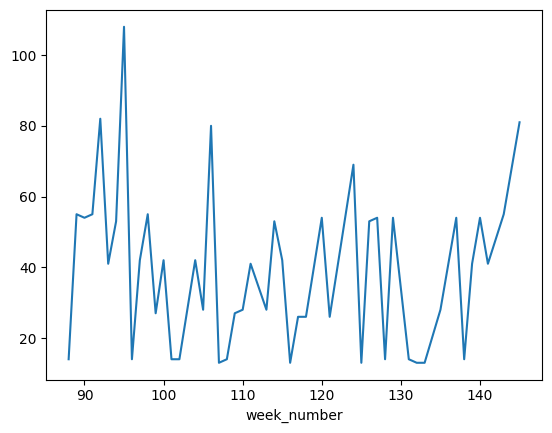

In [62]:
df_nulls[(df_nulls.city_id == 4) & (df_nulls.meal_id == 8)].groupby("week_number").num_orders.sum().plot()

<Axes: xlabel='week_number'>

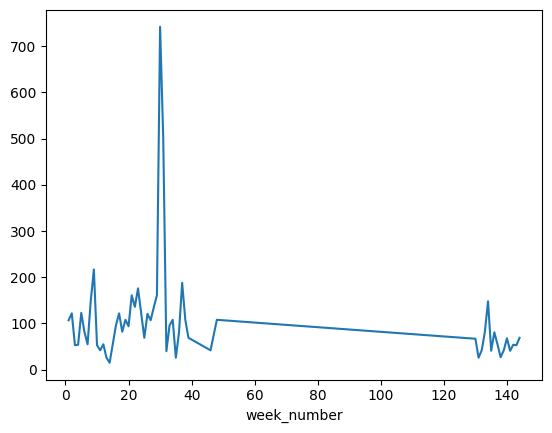

In [63]:
# Some city/meal combinations have sparse data, need to fill these with 0

df_nulls[(df_nulls.city_id == 13) & (df_nulls.meal_id == 37)].groupby("week_number").num_orders.sum().plot()

In [64]:
def add_rolling_features(df_):
    df = df_.copy()

    print("Adding rolling features")

    g = ["city_id", "meal_id"]

    # Shift target (predict for next week)
    df["next_week_num_orders"] = df.groupby(g).num_orders.shift(-1).fillna(0)

    # Num next week orders from last year
    df["num_orders_last_year"] = df.groupby(g).next_week_num_orders.shift(52).fillna(0)

    # Num orders from past week
    df["num_orders_last_week"] = df.groupby(g).num_orders.shift(1).fillna(0)

    # Num orders rolling average past 4 weeks
    df["num_orders_rolling_4_weeks"] = (
        df.groupby(g).next_week_num_orders.rolling(4).mean().reset_index()
            .sort_values("level_2").drop(columns=g)
            .set_index("level_2").next_week_num_orders.fillna(0)
    )

    # Num orders rolling average past 16 weeks
    df["num_orders_rolling_16_weeks"] = (
        df.groupby(g).next_week_num_orders.rolling(16).mean().reset_index()
            .sort_values("level_2").drop(columns=g)
            .set_index("level_2").next_week_num_orders.fillna(0)
    )

    # Num order rolling averages from same week last year
    df["num_orders_last_year_rolling_4_weeks"] = df.groupby(g).num_orders_rolling_4_weeks.shift(52).fillna(0)
    df["num_orders_last_year_rolling_16_weeks"] = df.groupby(g).num_orders_rolling_16_weeks.shift(52).fillna(0)

    # Drop first year and last week 
    df_final_week = df[df.week_number == 145].copy()
    df = df[(df.week_number > 52) & (df.week_number != 145)].copy()

    print("Done adding rolling features")
    return df, df_final_week


df, df_final_week = add_rolling_features(df)

Adding rolling features
Done adding rolling features


In [65]:
df.isnull().sum()

week_number                              0
emailer_for_promotion                    0
homepage_featured                        0
num_orders                               0
op_area                                  0
Meat                                     0
Other                                    0
Seafood                                  0
Vegetarian                               0
beverage                                 0
dessert                                  0
main                                     0
side                                     0
starter                                  0
city_id                                  0
meal_id                                  0
base_price_normed                        0
checkout_price_normed                    0
price_diff                               0
month_num                                0
quarter_num                              0
year_num                                 0
next_week_num_orders                     0
num_orders_

In [66]:
df_final_week.isnull().sum()

week_number                              0
emailer_for_promotion                    0
homepage_featured                        0
num_orders                               0
op_area                                  0
Meat                                     0
Other                                    0
Seafood                                  0
Vegetarian                               0
beverage                                 0
dessert                                  0
main                                     0
side                                     0
starter                                  0
city_id                                  0
meal_id                                  0
base_price_normed                        0
checkout_price_normed                    0
price_diff                               0
month_num                                0
quarter_num                              0
year_num                                 0
next_week_num_orders                     0
num_orders_

In [67]:
# Cannot use final week for training

(df_final_week.next_week_num_orders != 0).sum()

np.int64(0)

In [68]:
# Generate forecast starting from this week

df_final_week.drop(columns=["next_week_num_orders"]).to_csv("../data/final_week_processed.csv", index=False)

In [69]:
df.to_csv("../data/train_processed.csv", index=False)

In [70]:
!ls ../data

final_week_processed.csv   meal_demand_historical.csv
full_clean_encoded.csv     train_processed.csv


In [71]:
df.head().T

,152332,152333,152334,152335,152336
week_number,53.000000,53.000000,53.000000,53.000000,53.000000
emailer_for_promotion,1.000000,1.000000,1.000000,0.000000,0.000000
homepage_featured,1.000000,1.000000,1.000000,0.000000,0.000000
num_orders,500.000000,1161.000000,959.000000,13.000000,68.000000
op_area,2.000000,2.000000,2.000000,2.000000,2.000000
Meat,0.000000,1.000000,1.000000,0.000000,0.000000
Other,0.000000,0.000000,0.000000,0.000000,0.000000
Seafood,0.000000,0.000000,0.000000,0.000000,1.000000
Vegetarian,1.000000,0.000000,0.000000,1.000000,0.000000
beverage,0.000000,0.000000,0.000000,0.000000,0.000000


## 6. Simple Model

In [72]:
# Number of orders last year, scaled up by Y/Y rolling average change

def simple_predict_1(df):
    adjusted_num_orders_last_year_rolling_4_weeks = df.num_orders_last_year_rolling_4_weeks.where(lambda x: x != 0, df.num_orders_rolling_4_weeks)
    return df.num_orders_last_year * (df.num_orders_rolling_4_weeks / adjusted_num_orders_last_year_rolling_4_weeks)

def get_mse(df, predict_func):
    return ((predict_func(df) - df.num_orders)**2).mean()

get_mse(df, simple_predict_1)

np.float64(66818.4939114343)

In [73]:
# Rolling average
# WINNER

def simple_predict_2(df):
    return df.num_orders_rolling_4_weeks

get_mse(df, simple_predict_2)

np.float64(28736.491762128455)

In [74]:
# Same as number of orders last week

def simple_predict_3(df):
    return df.num_orders_last_week

get_mse(df, simple_predict_3)

np.float64(72574.79588003407)

## 7. Train-Test Splits

In [75]:
# Pre/post split for temporal data

train_test_split_week = int(df.iloc[int(len(df) * 0.90)].week_number) # 10% test set
train_test_split_week

135

In [76]:
df_train = df[df.week_number < train_test_split_week].copy()
df_test = df[df.week_number >= train_test_split_week].copy()

In [77]:
len(df_train)

259198

In [78]:
len(df_test)

32018

## 8. Gradient-Boosted Model Hyperparameter Optimization

In [79]:

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Example from [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

```python
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
Fold 0:
  Train: index=[0]
  Test:  index=[1]
Fold 1:
  Train: index=[0 1]
  Test:  index=[2]
Fold 2:
  Train: index=[0 1 2]
  Test:  index=[3]
Fold 3:
  Train: index=[0 1 2 3]
  Test:  index=[4]
Fold 4:
  Train: index=[0 1 2 3 4]
  Test:  index=[5]
```

In [80]:
# This cell will take a very long time to run (it took me ~2 hours)

X = df_train.drop(columns="next_week_num_orders")
y = df_train["next_week_num_orders"]

# Define the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Define the gradient boosting regressor model
gbr = GradientBoostingRegressor()

# Define the parameter grid to search
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 0.9, 1.0],
    "min_samples_split": [2, 5, 10]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Model:", best_model)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=  13.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.9; total time=  14.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=  15.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=  27.5s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.9; total time=  30.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=1.0; total time=  32.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200, subsample=0.8; total time=  24.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100, subsample=0.8; total time=  42.5s
[CV] END learning

In [95]:
dir(grid_search)
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 300,
 'subsample': 0.8}

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_search_results(grid):
    """
    https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score Per Parameter, All Other Values Fixed to Best')
    fig.text(0.04, 0.5, 'Mean Test Score', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p)

    plt.legend()
    plt.show()


```python
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
```

In [96]:
param_grid

{'n_estimators': [100, 200, 300],
 'learning_rate': [0.01, 0.05, 0.1],
 'max_depth': [3, 4, 5],
 'subsample': [0.8, 0.9, 1.0],
 'min_samples_split': [2, 5, 10]}

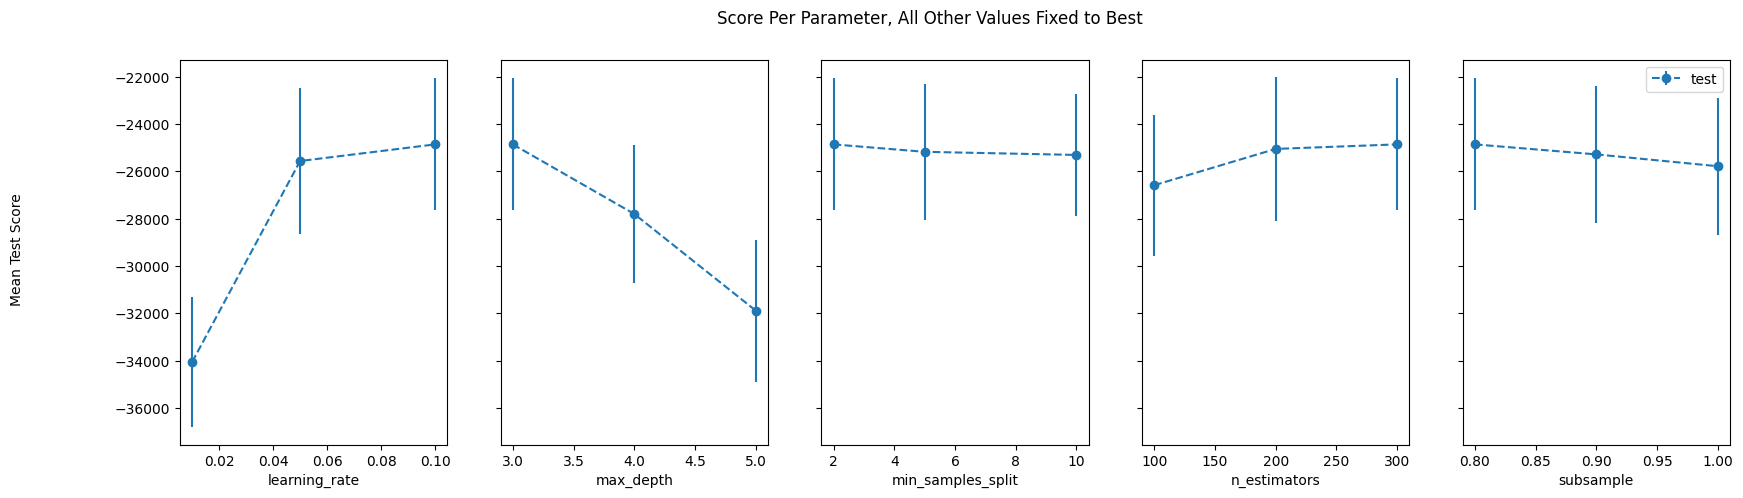

In [82]:
plot_search_results(grid_search)

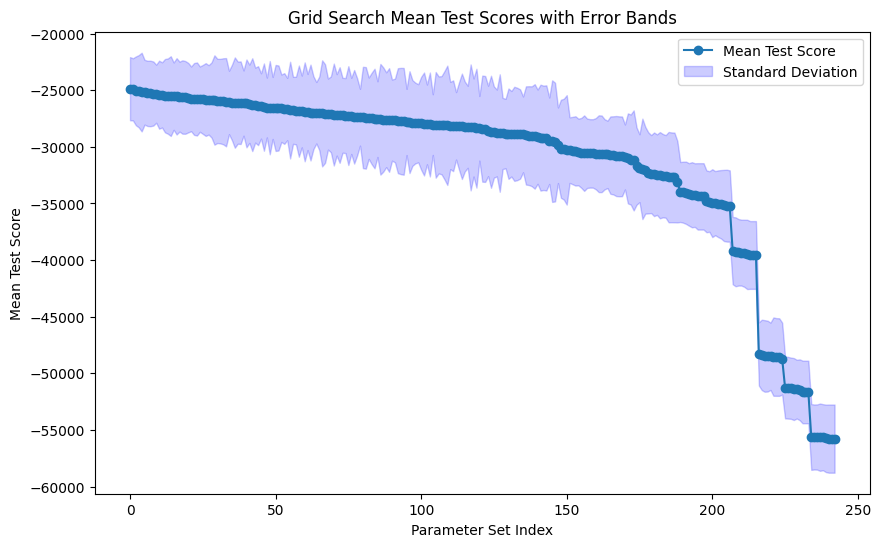

In [83]:

# Extract the mean test scores and standard deviation of test scores from grid search results
mean_test_scores = grid_search.cv_results_["mean_test_score"]
std_test_scores = grid_search.cv_results_["std_test_score"]

# Sort the scores in descending order
sorted_indices = np.argsort(mean_test_scores)[::-1]
sorted_mean_test_scores = mean_test_scores[sorted_indices]
sorted_std_test_scores = std_test_scores[sorted_indices]

# Generate the x values
x_values = range(len(sorted_mean_test_scores))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, sorted_mean_test_scores, label='Mean Test Score', marker='o')
plt.fill_between(x_values, 
                 sorted_mean_test_scores - sorted_std_test_scores, 
                 sorted_mean_test_scores + sorted_std_test_scores, 
                 color='b', alpha=0.2, label='Standard Deviation')

# Adding labels and title
plt.xlabel('Parameter Set Index')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Mean Test Scores with Error Bands')
plt.legend()

# Show the plot
plt.show()


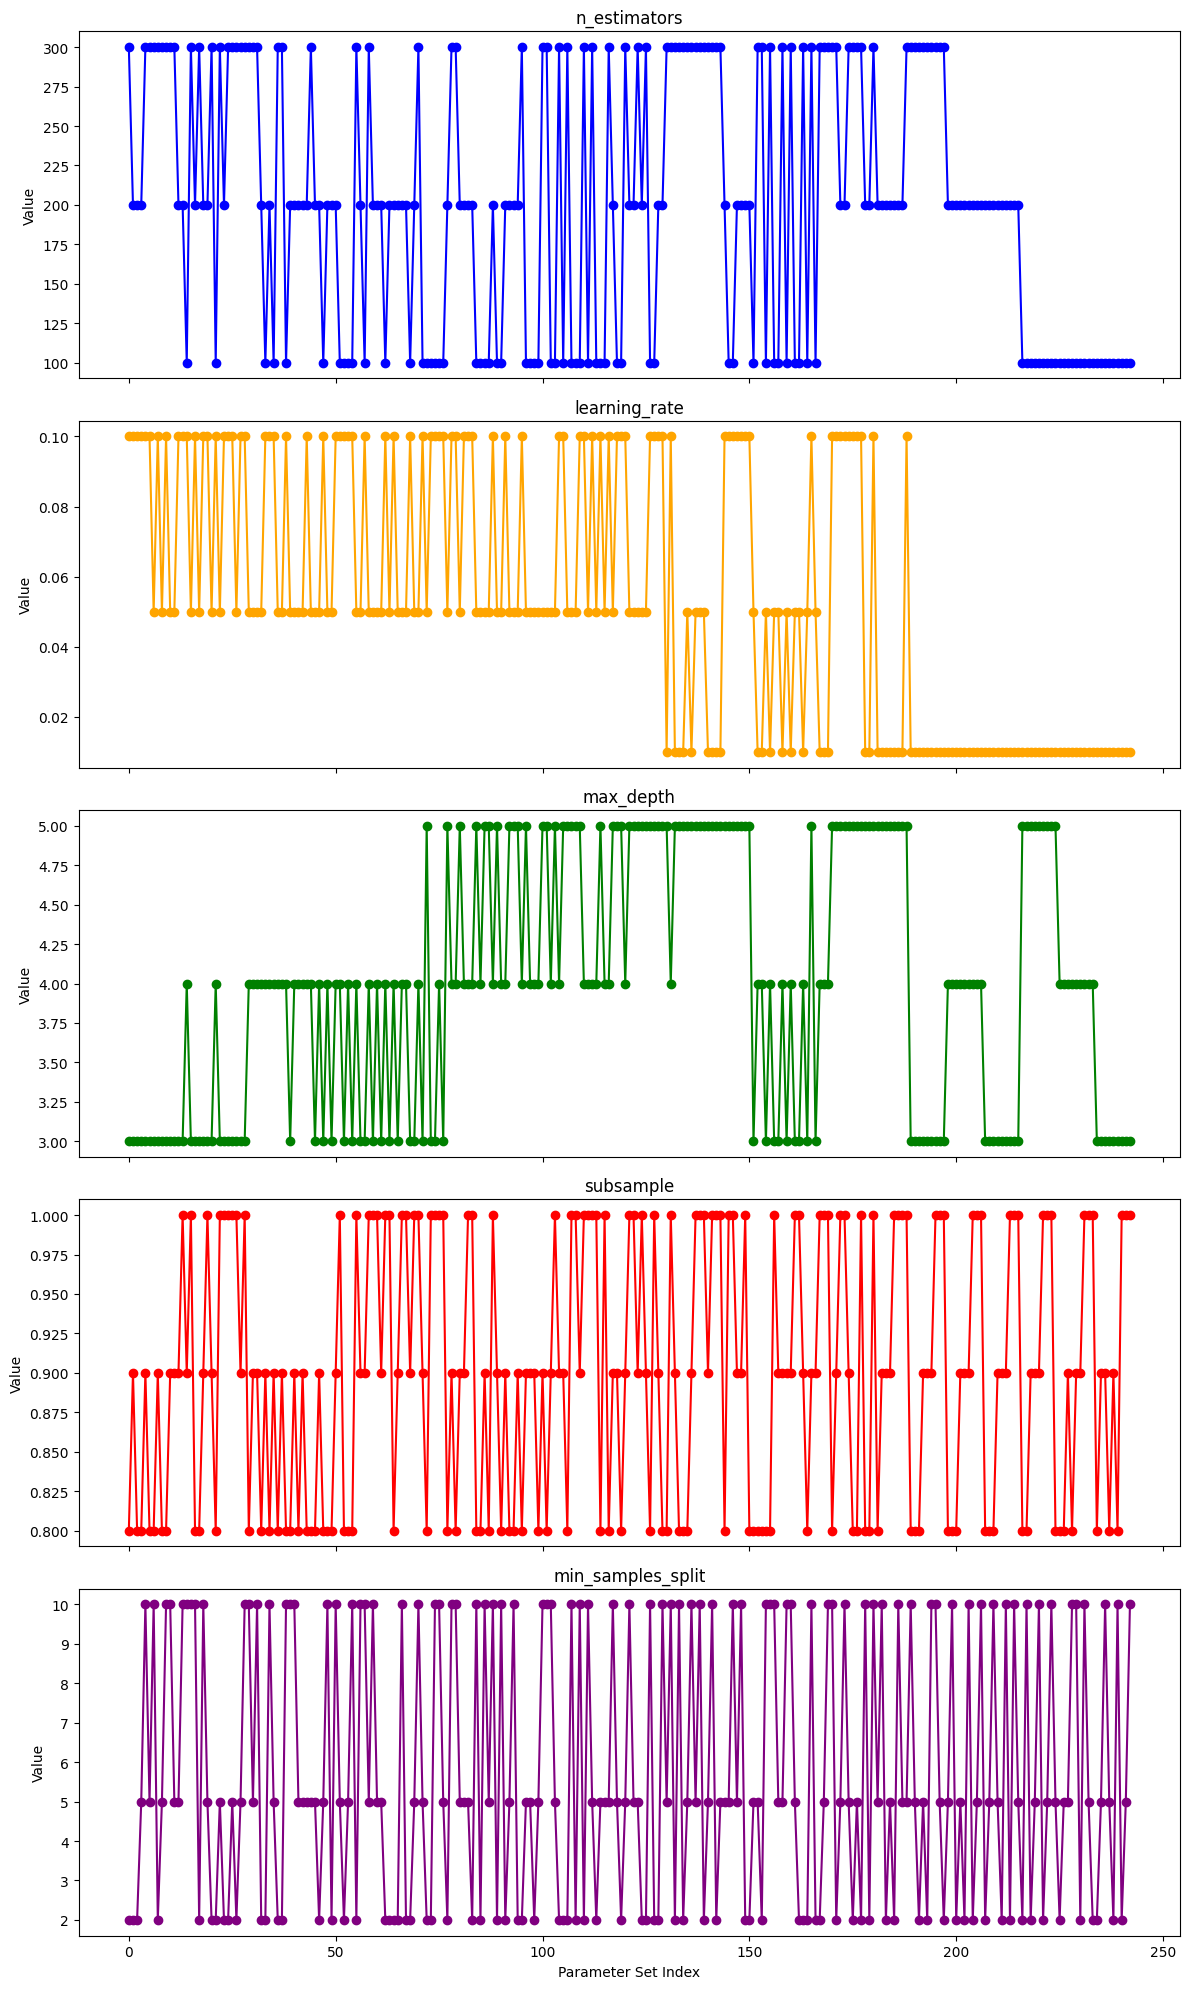

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the mean test scores and sort them in descending order
mean_test_scores = grid_search.cv_results_["mean_test_score"]
sorted_indices = np.argsort(mean_test_scores)[::-1]

# Extract the sorted parameters based on the sorted indices
params = grid_search.cv_results_['params']
sorted_params = [params[i] for i in sorted_indices]

# Extract values of each hyperparameter
n_estimators = [param['n_estimators'] for param in sorted_params]
learning_rates = [param['learning_rate'] for param in sorted_params]
max_depths = [param['max_depth'] for param in sorted_params]
subsamples = [param['subsample'] for param in sorted_params]
min_samples_splits = [param['min_samples_split'] for param in sorted_params]

# Generate the x values for the subplots
x_values = range(len(sorted_mean_test_scores))

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)

# Plot each hyperparameter on a different subplot
axs[0].plot(x_values, n_estimators, marker='o', color='blue')
axs[0].set_title('n_estimators')
axs[0].set_ylabel('Value')

axs[1].plot(x_values, learning_rates, marker='o', color='orange')
axs[1].set_title('learning_rate')
axs[1].set_ylabel('Value')

axs[2].plot(x_values, max_depths, marker='o', color='green')
axs[2].set_title('max_depth')
axs[2].set_ylabel('Value')

axs[3].plot(x_values, subsamples, marker='o', color='red')
axs[3].set_title('subsample')
axs[3].set_ylabel('Value')

axs[4].plot(x_values, min_samples_splits, marker='o', color='purple')
axs[4].set_title('min_samples_split')
axs[4].set_ylabel('Value')
axs[4].set_xlabel('Parameter Set Index')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [85]:
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 300,
 'subsample': 0.8}

In [86]:
# Train best model on full training set, then eval on test set

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X_train = df_train.drop(columns="next_week_num_orders")
y_train = df_train["next_week_num_orders"]
X_test = df_test.drop(columns="next_week_num_orders")
y_test = df_test["next_week_num_orders"]

# Define the best hyperparameters obtained from the grid search

best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_samples_split': 2,
    'n_estimators': 300,
    'subsample': 0.8
}

# Initialize the GradientBoostingRegressor with the best parameters
best_model = GradientBoostingRegressor(**best_params)

# Train the model on the full training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Mean Squared Error on Test Set: 16555.76827283058


In [87]:
# Train on full dataset and save

X = df.drop(columns="next_week_num_orders")
y = df["next_week_num_orders"]

# Define the best hyperparameters obtained from the grid search
best_params = {
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_samples_split": 10,
    "n_estimators": 100,
    "subsample": 0.8
}

# Initialize the GradientBoostingRegressor with the best parameters
best_model = GradientBoostingRegressor(**best_params)

# Train the model on the full training set
best_model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=10,
                          subsample=0.8)

In [97]:
def store_model(model_name, model, artifact_path="../artifacts"):
    Path(artifact_path).mkdir(exist_ok=True, parents=True)
    with open(Path(artifact_path) / f"{model_name}.pkl", "wb") as f:
        dump(model, f)

store_model("boosted_tree", best_model)

In [99]:
!ls ../artifacts/

boosted_tree.pkl         meal_info_encoder.pkl    price_scaler_encoder.pkl
city_name_encoder.pkl    meal_name_encoder.pkl


## 9. Train a Stack of Models

In [90]:
df.columns

Index(['week_number', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'op_area', 'Meat', 'Other', 'Seafood', 'Vegetarian',
       'beverage', 'dessert', 'main', 'side', 'starter', 'city_id', 'meal_id',
       'base_price_normed', 'checkout_price_normed', 'price_diff', 'month_num',
       'quarter_num', 'year_num', 'next_week_num_orders',
       'num_orders_last_year', 'num_orders_last_week',
       'num_orders_rolling_4_weeks', 'num_orders_rolling_16_weeks',
       'num_orders_last_year_rolling_4_weeks',
       'num_orders_last_year_rolling_16_weeks'],
      dtype='object')

In [91]:
from tqdm import tqdm

In [100]:
model_params = {
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_samples_split": 10,
    "n_estimators": 100,
    "subsample": 0.8
}

num_future_weeks = 12
for future_week_num in tqdm(list(range(1, num_future_weeks+1))):
    # 1, 2, 3, 4... 12

    if future_week_num == 1:
        df_i = df.rename(columns={"next_week_num_orders": "target_num_orders"}).copy()
    else:
        # Shift target (predict for following week)
        df_i["target_num_orders"] = df_i.sort_values("week_number", ascending=True).groupby(["city_id", "meal_id"]).target_num_orders.shift(-1)
        df_i = df_i.dropna().copy()

    print(f"week_num={future_week_num}")
    print(f"len(df)={int(len(df_i))}")
    print(f"max_week={int(df_i.week_number.max())}")

    X = df_i.drop(columns="target_num_orders")
    y = df_i["target_num_orders"]
    model = GradientBoostingRegressor(**model_params)

    model.fit(X, y)

    store_model(f"boosted_tree_stack_week_{future_week_num}", model)


  0%|          | 0/12 [00:00<?, ?it/s]

week_num=1
len(df)=291216
max_week=144


  8%|▊         | 1/12 [01:16<14:02, 76.56s/it]

week_num=2
len(df)=287678
max_week=143


 17%|█▋        | 2/12 [02:31<12:36, 75.68s/it]

week_num=3
len(df)=284146
max_week=142


 25%|██▌       | 3/12 [03:45<11:14, 74.91s/it]

week_num=4
len(df)=280615
max_week=141


 33%|███▎      | 4/12 [04:58<09:52, 74.10s/it]

week_num=5
len(df)=277086
max_week=140


 42%|████▏     | 5/12 [06:10<08:33, 73.34s/it]

week_num=6
len(df)=273560
max_week=139


 50%|█████     | 6/12 [07:21<07:14, 72.42s/it]

week_num=7
len(df)=270039
max_week=138


 58%|█████▊    | 7/12 [08:30<05:57, 71.57s/it]

week_num=8
len(df)=266523
max_week=137


 67%|██████▋   | 8/12 [09:39<04:42, 70.71s/it]

week_num=9
len(df)=263010
max_week=136


 75%|███████▌  | 9/12 [10:47<03:29, 69.76s/it]

week_num=10
len(df)=259498
max_week=135


 83%|████████▎ | 10/12 [11:54<02:17, 68.79s/it]

week_num=11
len(df)=255988
max_week=134


 92%|█████████▏| 11/12 [12:59<01:07, 67.87s/it]

week_num=12
len(df)=252482
max_week=133


100%|██████████| 12/12 [14:04<00:00, 70.38s/it]


In [93]:
!ls ../artifacts/

boosted_tree.pkl               boosted_tree_stack_week_6.pkl
boosted_tree_stack_week_1.pkl  boosted_tree_stack_week_7.pkl
boosted_tree_stack_week_10.pkl boosted_tree_stack_week_8.pkl
boosted_tree_stack_week_11.pkl boosted_tree_stack_week_9.pkl
boosted_tree_stack_week_12.pkl city_name_encoder.pkl
boosted_tree_stack_week_2.pkl  meal_info_encoder.pkl
boosted_tree_stack_week_3.pkl  meal_name_encoder.pkl
boosted_tree_stack_week_4.pkl  price_scaler_encoder.pkl
boosted_tree_stack_week_5.pkl
